# Problem definiton
**Segmentation of gliomas in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
* Anything else -> pixel is not on a tumor region (0)

The sub-regions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT)
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else.



![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

# Set up

In [1]:
import os
import re
import cv2
import glob
import PIL
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ml libs
import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2024-02-17 10:15:59.507841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 10:15:59.507942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 10:15:59.643577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Constants

In [2]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

N_CLASSES = len(SEGMENT_CLASSES.keys())

# there are 155 slices per volume
# we shall skip the first 22 and get the subsequent 100 slices
VOLUME_START_AT = 22
VOLUME_SLICES = 100 

ORG_IMG_SIZE = 240
IMG_SIZE = 128

TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# Data Pipeline

In [3]:
def generate_train_val_test_ids():
    # lists of directories with studies
    train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

    # file BraTS20_Training_355 has ill formatted name for for seg.nii file
    train_and_val_directories.remove(os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355'))

    train_and_test_ids = [x.split("/")[-1] for x in train_and_val_directories]; 

    train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
    train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)
    
    return train_ids, val_ids, test_ids

In [4]:
class UnimodalDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ids, batch_size=1, scan="flair", shuffle=True):
        if scan not in ["flair", "t1", "t2", "t1ce"]:
            raise RuntimeError(f"Unsupported scan provided: {scan}")
        
        self.ids = ids
        self.batch_size = batch_size
        self.scan = scan
        
        self.x_shape = (self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 1)
        self.y_pre_enc_shape = (self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE)
        self.y_shape = (self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE, N_CLASSES)
        
        self.sample_shape = self.x_shape[1:]
        
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.ids) / self.batch_size))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch_ids = [self.ids[k] for k in indexes]

        # Generate data
        X, Y = self.__get_batch(batch_ids)

        return X, Y

    def __get_batch(self, batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros(self.x_shape)
        Y_pre = np.zeros(self.y_pre_enc_shape)
        Y = np.zeros(self.y_shape)

        # Fill in data
        for batch_index, batch_id in enumerate(batch_ids):
            sample_path = os.path.join(TRAIN_DATASET_PATH, batch_id)
            
            # load scans
            scan_path = os.path.join(sample_path, f'{batch_id}_{self.scan}.nii');
            scan_img = nib.load(scan_path).get_fdata()    

            # load segmentation mask
            seg_path = os.path.join(sample_path, f'{batch_id}_seg.nii');
            seg_img = nib.load(seg_path).get_fdata()
            
            # fill in slices
            for j in range(VOLUME_SLICES):
                X[j+VOLUME_SLICES*batch_index,:,:,0] = cv2.resize(scan_img[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                Y_pre[j+VOLUME_SLICES*batch_index] = cv2.resize(seg_img[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
        # Process masks
        Y_pre[Y_pre==4] = 3 # relabel
        Y = tf.one_hot(Y_pre, 4)
        
        return tf.convert_to_tensor(X), Y

# U-Net Model

In [5]:
@tf.keras.saving.register_keras_serializable()
class DivideByMax(tf.keras.layers.Layer):
    """
    Normalization layer
    
    It's better to include the normalization layer in the model architecture itself, rather than in the data generator.
    This ensures that the end user does not have to worry about normalization during inference.
    """
    
    def __init__(self, **kwargs):
        super(DivideByMax, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs / tf.math.reduce_max(inputs, axis=(1, 2, 3), keepdims=True)
    
    def get_config(self):
        return {}
    

@tf.keras.saving.register_keras_serializable()
class MeanStdNormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MeanStdNormLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2, 3], keepdims=True)
        normalized_inputs = (inputs - mean) / tf.sqrt(variance + 1e-8)
        return normalized_inputs
    
    def get_config(self):
        return {}

In [6]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def conv_block(x, filters, names, kernel_size=3, activation="relu", padding="same", kernel_initializer="glorot_uniform"):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name=names[0])(x)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name=names[1])(conv)
    return conv

def encoder_block(x, filters, names, kernel_size=3, activation="relu", padding="same", kernel_initializer="glorot_uniform", pool_size=(2, 2)):
    x = conv_block(x, filters, names[:-1], kernel_size, activation, padding, kernel_initializer)
    p = MaxPooling2D(pool_size=pool_size, name=names[-1])(x)
    return x, p
    
def decoder_block(x, cat_x, filters, names, upsample_size=2, kernel_size=2, activation="relu", padding="same", kernel_initializer="glorot_uniform"):
    up = UpSampling2D(size=upsample_size, name=names[0])(x)
    pre_conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name=names[1])(up)
    merge = concatenate([cat_x, pre_conv], axis=-1, name=names[2])
    conv = conv_block(merge, filters, names[3:], kernel_size, activation, padding, kernel_initializer)
    return conv

def get_input_name():
    return "input"

def get_norm_name():
    return "norm"

def get_encoder_block_names(block_order):
    return [f"encoder_block{block_order}_conv1", f"encoder_block{block_order}_conv2", f"encoder_block{block_order}_pool"]

def get_bridge_name():
    return ["bridge_conv1", "bridge_conv2"]

def get_dropout_name():
    return "dropout"

def get_decoder_block_names(block_order):
    return [f"decoder_block{block_order}_up", f"decoder_block{block_order}_conv1", f"decoder_block{block_order}_concat", 
            f"decoder_block{block_order}_conv2", f"decoder_block{block_order}_conv3"]

def get_output_conv_name():
    return "segmentation"

def build_unet(input_shape, dropout=0.2):
    inputs = Input(input_shape, name=get_input_name())
    
    inputs_norm = MeanStdNormLayer(name=get_norm_name())(inputs)

    # encoder
    x1, p1 = encoder_block(inputs_norm, 16, names=get_encoder_block_names(1))
    x2, p2 = encoder_block(p1, 32, names=get_encoder_block_names(2))
    x3, p3 = encoder_block(p2, 64, names=get_encoder_block_names(3))
    x4, p4 = encoder_block(p3, 128, names=get_encoder_block_names(4))
    
    # bridge
    bridge = conv_block(p4, 256, names=get_bridge_name())
    drop = Dropout(dropout, name=get_dropout_name())(bridge)
    
    # decoder
    u4 = decoder_block(drop, x4, 128, names=get_decoder_block_names(1))
    u3 = decoder_block(u4, x3, 64, names=get_decoder_block_names(2))
    u2 = decoder_block(u3, x2, 32, names=get_decoder_block_names(3))
    u1 = decoder_block(u2, x1, 32, names=get_decoder_block_names(4))
    
    outputs = Conv2D(N_CLASSES, (1,1), activation='softmax', name=get_output_conv_name())(u1)
    
    return Model(inputs=inputs, outputs=outputs)

# Training Helpers

Example model directory:

```
model
|- training.log
|- model
       |- model_.{epoch:02d}-{val_loss:.6f}.keras
       |- model_.{epoch:02d}-{val_loss:.6f}.keras
       |- model_.{epoch:02d}-{val_loss:.6f}.keras
```

In [7]:
def setup_model_files(model_path):
    model_iterations_path = os.path.join(model_path, model_path)
    log_file_path = os.path.join(model_path, "training.log")
    
    # make directories
    if not os.path.exists(model_path):
        os.mkdir(model_path)
        os.mkdir(model_iterations_path)
    
    # make empty log file
    open(log_file_path, 'w')
    
    return {
        "model_path": model_path,
        "model_iterations_path": model_iterations_path,
        "log_file_path": log_file_path,
    }

In [8]:
def get_callbacks(model_iterations_path, log_file_path):
    return [
        EarlyStopping(monitor='loss', min_delta=0,
                                  patience=2, verbose=1, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=2, min_lr=0.000001, verbose=1),
        ModelCheckpoint(filepath=os.path.join(model_iterations_path, 'model_.{epoch:02d}-{val_loss:.6f}.keras'),
                                verbose=1, save_best_only=True),
        CSVLogger(log_file_path, separator=',', append=False)
    ]

In [9]:
def get_and_compile_model(input_shape, dropout=0.2, lr=0.001, loss_fn="categorical_crossentropy"):
    model = build_unet(input_shape, dropout)
    
    model.compile(
        loss=loss_fn, 
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        metrics = [
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=N_CLASSES),
        ]
    )
    
    return model

In [10]:
def plot_history(hist):
    for key in hist.keys():
        match = re.search(f"^mean_io_u[_+\d]*", key)
        if match:
            mean_iou_key = match.string
    
    loss = hist['loss']
    acc = hist['accuracy']
    iou = hist[mean_iou_key]

    val_loss = hist['val_loss']
    val_acc = hist['val_accuracy']
    val_iou = hist['val_' + mean_iou_key]

    epoch = range(len(acc))
    
    f,ax=plt.subplots(1,3,figsize=(16,4))

    ax[0].plot(epoch, acc, label='Training Accuracy')
    ax[0].plot(epoch, val_acc, label='Validation Accuracy')
    ax[0].set_xticks(epoch)
    ax[0].legend()

    ax[1].plot(epoch, loss, label='Training Loss')
    ax[1].plot(epoch, val_loss, label='Validation Loss')
    ax[1].set_xticks(epoch)
    ax[1].legend()

    ax[2].plot(epoch, iou, label='Training mean IOU')
    ax[2].plot(epoch, val_iou, label='Validation mean IOU')
    ax[2].set_xticks(epoch)
    ax[2].legend()

    plt.show()

In [11]:
def evaluate_unimodal_model(model, test_gen, scan, evaluate_n=5):
    x_batch, y_batch = next(iter(test_gen))
    prediction = model.predict(x_batch)
    
    nrows = evaluate_n
    ncols = 6
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, evaluate_n*2))
    
    for i in range(nrows):
        
        index = random.choice(range(len(x_batch)))
        x_sample = x_batch[index] # (128, 128, n_scans)
        y_sample = y_batch[index] # (128, 128, N_CLASSES)
        pred = prediction[index] # (128, 128, N_CLASSES)
        
        # give each plot a brain background
        for j in range(ncols):
            axs[i][j].imshow(x_sample[:, :, 0], cmap="gray", interpolation='none')
            
        axs[i][0].imshow(x_sample[:, :, 0], cmap="gray")
        axs[i][0].title.set_text(f"{scan}")
        axs[i][0].axis("off")
                        
        axs[i][1].imshow(tf.math.argmax(y_sample, axis=-1), cmap="Reds", interpolation='none', alpha=0.3)
        axs[i][1].title.set_text('Ground truth: all classes')
        axs[i][1].axis("off")
        
        axs[i][2].imshow(tf.math.argmax(pred, axis=-1), cmap="Reds", interpolation='none', alpha=0.3)
        axs[i][2].title.set_text('Prediction: all classes')
        axs[i][2].axis("off")
                        
        axs[i][3].imshow(pred[:, :, 1], cmap="OrRd", interpolation='none', alpha=0.3)
        axs[i][3].title.set_text(f'Prediction: {SEGMENT_CLASSES[1]}')
        axs[i][3].axis("off")
                        
        axs[i][4].imshow(pred[:, :, 2], cmap="OrRd", interpolation='none', alpha=0.3)
        axs[i][4].title.set_text(f'Prediction: {SEGMENT_CLASSES[2]}')
        axs[i][4].axis("off")
                        
        axs[i][5].imshow(pred[:, :, 3], cmap="OrRd", interpolation='none', alpha=0.3)
        axs[i][5].title.set_text(f'Prediction: {SEGMENT_CLASSES[3]}')
        axs[i][5].axis("off")

    plt.show()

In [12]:
def run_training_job(
    model_path, # path to model
    scan,
    batch_size, 
    epochs,
    lr=0.001,
):
    print(f"=========================================================")
    print(f"==== | RUNNING TRAINING JOB FOR {model_path} | ====")
    print(f"=========================================================\n\n")
    
    print("<> Setting up files <>\n")
    paths = setup_model_files(model_path)

    print("<> Setting up callbacks <>\n")
    callbacks = get_callbacks(
        paths["model_iterations_path"],
        paths["log_file_path"]
    )

    print(f"<> Building data generators <>\n")
    print(f"Batch size: {batch_size} * {VOLUME_SLICES}")
    
    train_ids, valid_ids, test_ids = generate_train_val_test_ids()
    
    train_gen = UnimodalDataGenerator(train_ids, scan=scan, batch_size=batch_size)
    valid_gen = UnimodalDataGenerator(valid_ids, scan=scan, batch_size=batch_size)
    test_gen = UnimodalDataGenerator(test_ids, scan=scan, batch_size=batch_size)

    print(f"Input shape: {train_gen.sample_shape}")
    print(f"X batch shape: {train_gen.x_shape}")
    print(f"Y batch shape: {train_gen.y_shape}\n")
    
    print("<> Building model <>\n")
    model = get_and_compile_model(
        input_shape=train_gen.sample_shape,
    )
    model.summary()
    print()
    
    print("<> Training! <>\n")
    
    print(f"Epochs: {epochs}")
    print(f"Training on scan: {scan}\n")
    
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        callbacks=callbacks,
    )
    
    print("\n\n<> Training complete! Plotting history! <>")
    plot_history(history.history)
    
    print("\n<> Evaluating model on test set <>")
    evaluate_unimodal_model(model, test_gen, scan, evaluate_n=5)
    
    return {
        "train_gen": train_gen,
        "valid_gen": valid_gen,
        "test_gen": test_gen,
        "model": model,
        "history": history,
        "paths": paths,
    }

# Training constants

In [13]:
EPOCHS = 10
BATCH_SIZE = 1

# Flair Unimodal Model

==== | RUNNING TRAINING JOB FOR flair_unimodal | ====


<> Setting up files <>

<> Setting up callbacks <>

<> Building data generators <>

Batch size: 1 * 100
Input shape: (128, 128, 1)
X batch shape: (100, 128, 128, 1)
Y batch shape: (100, 128, 128, 4)

<> Building model <>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 norm (MeanStdNormLayer)     (None, 128, 128, 1)          0         ['input[0][0]']               
                                                                                                  
 encoder_block1_conv1 (Conv  (None, 128, 128, 16)         160       ['norm[0][0]']                
 2D)          

2024-02-17 10:16:15.363307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708164980.905905      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9730 - mean_io_u: 0.5423
Epoch 1: val_loss improved from inf to 0.08523, saving model to flair_unimodal/flair_unimodal/model_.01-0.085233.keras
249/249 [==============================] - 146s 523ms/step - loss: 0.1567 - accuracy: 0.9730 - mean_io_u: 0.5423 - val_loss: 0.0852 - val_accuracy: 0.9850 - val_mean_io_u: 0.5322 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9826 - mean_io_u: 0.5769
Epoch 2: val_loss improved from 0.08523 to 0.04938, saving model to flair_unimodal/flair_unimodal/model_.02-0.049378.keras
249/249 [==============================] - 72s 290ms/step - loss: 0.0696 - accuracy: 0.9826 - mean_io_u: 0.5769 - val_loss: 0.0494 - val_accuracy: 0.9854 - val_mean_io_u: 0.5272 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9836 - mean_io_u: 0.4948
Epoch 3: val_loss improved from 0.0493

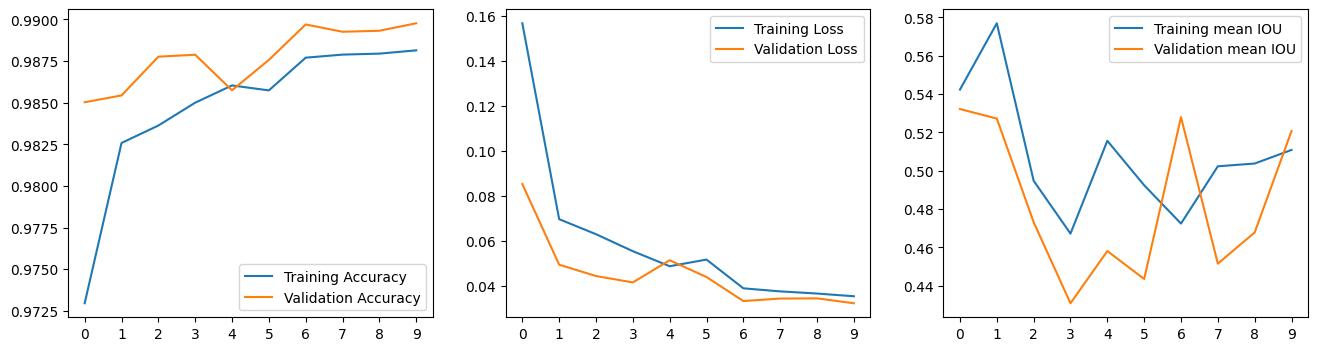


<> Evaluating model on test set <>
4/4 [==============================] - 2s 196ms/step


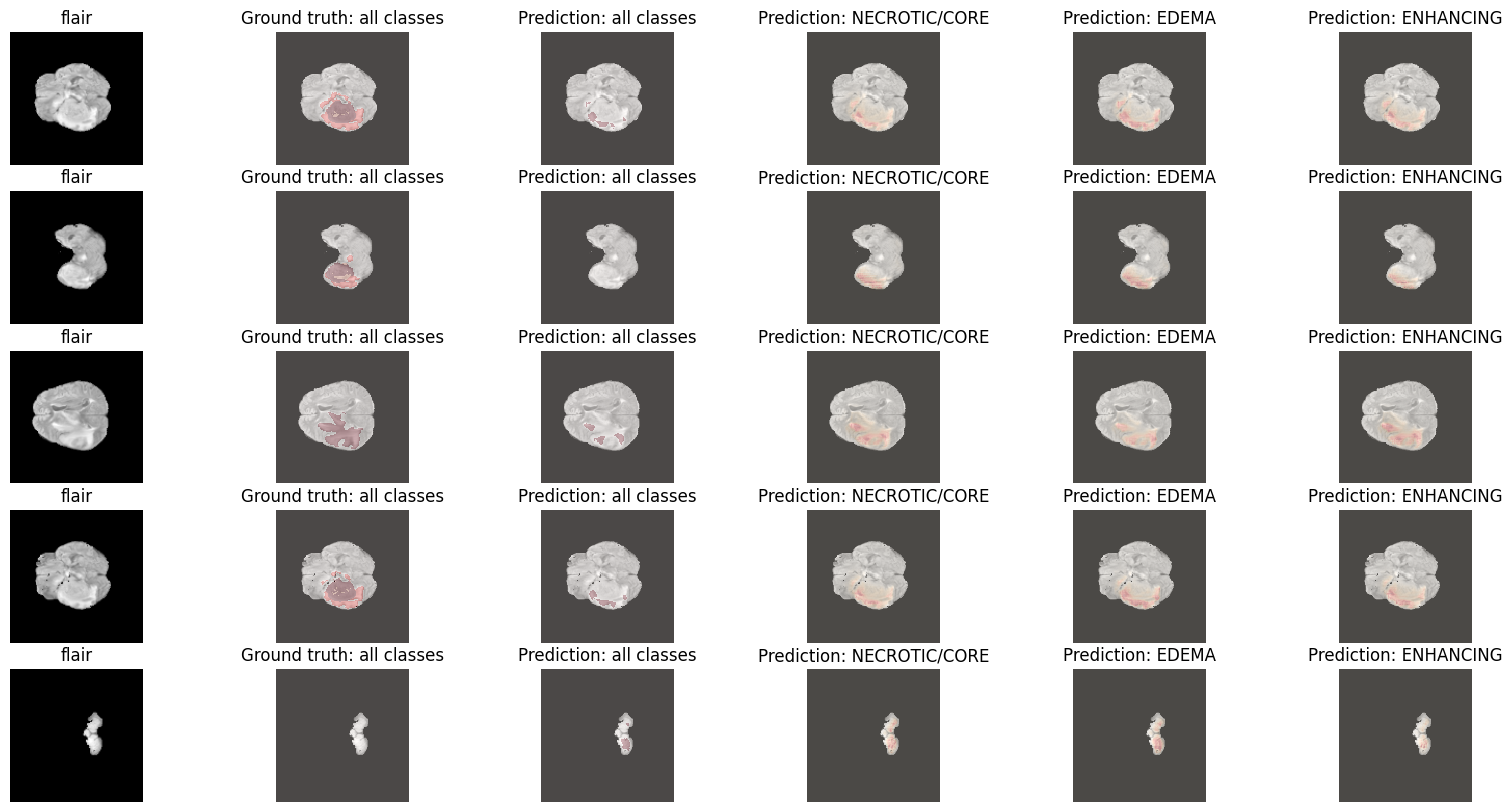

In [14]:
flair_results = run_training_job(
    model_path = "flair_unimodal",
    scan = "flair",
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    lr=0.0001
)

# T1CE Unimodal Model

==== | RUNNING TRAINING JOB FOR t1ce_unimodal | ====


<> Setting up files <>

<> Setting up callbacks <>

<> Building data generators <>

Batch size: 1 * 100
Input shape: (128, 128, 1)
X batch shape: (100, 128, 128, 1)
Y batch shape: (100, 128, 128, 4)

<> Building model <>

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 norm (MeanStdNormLayer)     (None, 128, 128, 1)          0         ['input[0][0]']               
                                                                                                  
 encoder_block1_conv1 (Conv  (None, 128, 128, 16)         160       ['norm[0][0]']                
 2D)         

2024-02-17 10:29:40.771401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9750 - mean_io_u_1: 0.5662
Epoch 1: val_loss improved from inf to 0.07930, saving model to t1ce_unimodal/t1ce_unimodal/model_.01-0.079303.keras
249/249 [==============================] - 116s 441ms/step - loss: 0.1177 - accuracy: 0.9750 - mean_io_u_1: 0.5662 - val_loss: 0.0793 - val_accuracy: 0.9829 - val_mean_io_u_1: 0.5842 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9836 - mean_io_u_1: 0.6396
Epoch 2: val_loss improved from 0.07930 to 0.07328, saving model to t1ce_unimodal/t1ce_unimodal/model_.02-0.073285.keras
249/249 [==============================] - 72s 289ms/step - loss: 0.0768 - accuracy: 0.9836 - mean_io_u_1: 0.6396 - val_loss: 0.0733 - val_accuracy: 0.9829 - val_mean_io_u_1: 0.6783 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9836 - mean_io_u_1: 0.6081
Epoch 3: val_loss improved f

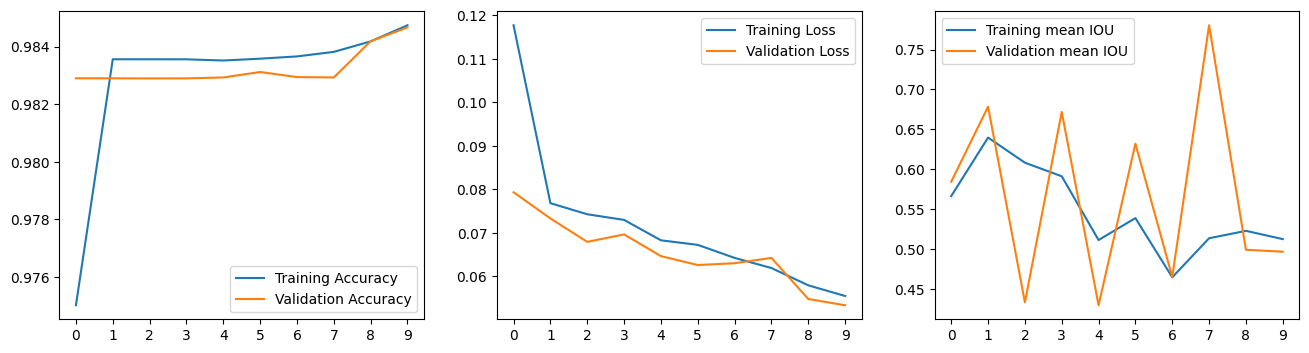


<> Evaluating model on test set <>
4/4 [==============================] - 0s 18ms/step


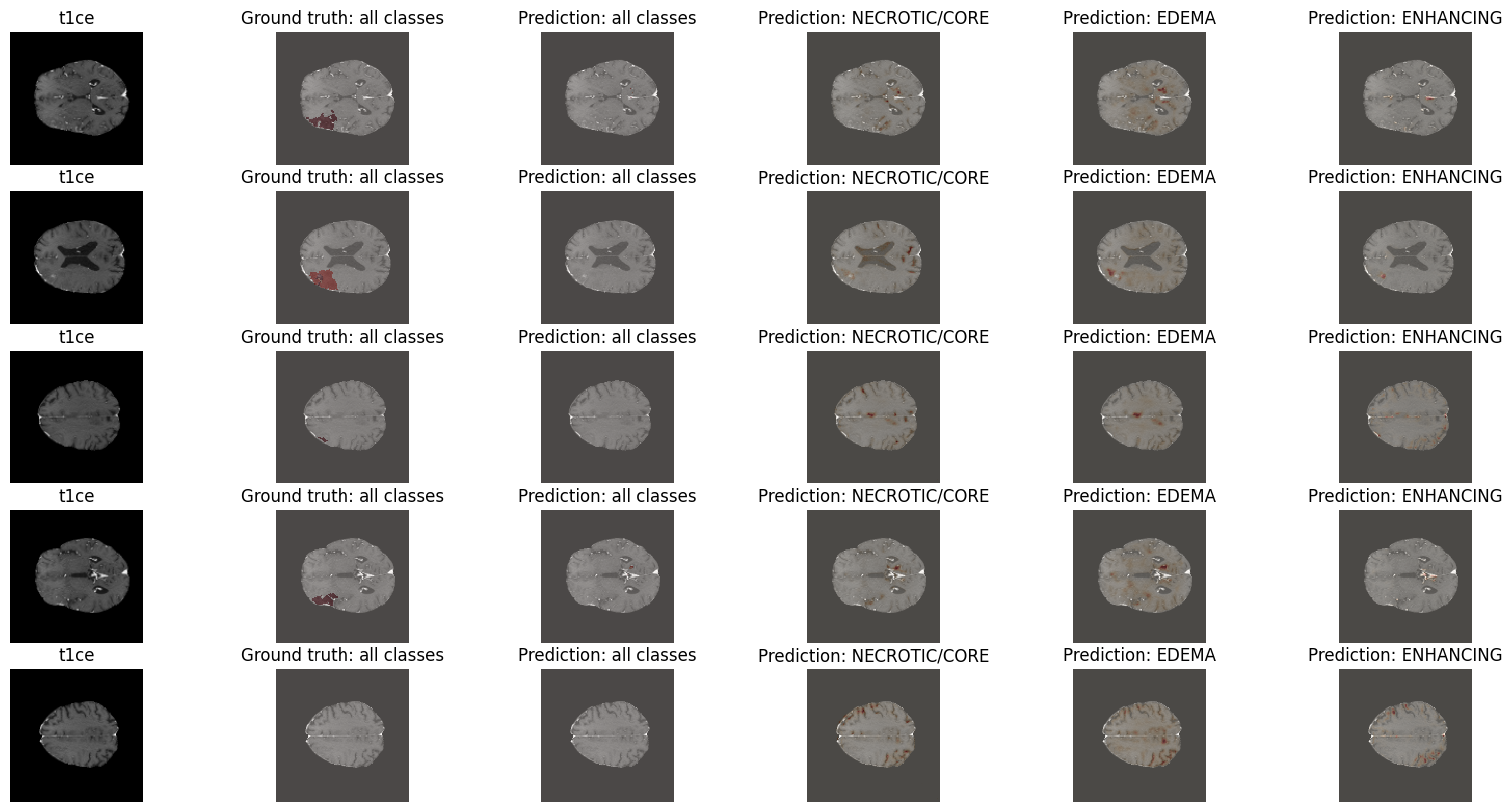

In [15]:
t1ce_results = run_training_job(
    model_path = "t1ce_unimodal",
    scan = "t1ce",
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    lr=0.0001
)

# T1 Unimodal Model

==== | RUNNING TRAINING JOB FOR t1_unimodal | ====


<> Setting up files <>

<> Setting up callbacks <>

<> Building data generators <>

Batch size: 1 * 100
Input shape: (128, 128, 1)
X batch shape: (100, 128, 128, 1)
Y batch shape: (100, 128, 128, 4)

<> Building model <>

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 norm (MeanStdNormLayer)     (None, 128, 128, 1)          0         ['input[0][0]']               
                                                                                                  
 encoder_block1_conv1 (Conv  (None, 128, 128, 16)         160       ['norm[0][0]']                
 2D)           

2024-02-17 10:42:36.934172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9797 - mean_io_u_2: 0.5691
Epoch 1: val_loss improved from inf to 0.07394, saving model to t1_unimodal/t1_unimodal/model_.01-0.073936.keras
249/249 [==============================] - 121s 459ms/step - loss: 0.1087 - accuracy: 0.9797 - mean_io_u_2: 0.5691 - val_loss: 0.0739 - val_accuracy: 0.9822 - val_mean_io_u_2: 0.5328 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9832 - mean_io_u_2: 0.5172
Epoch 2: val_loss did not improve from 0.07394
249/249 [==============================] - 77s 310ms/step - loss: 0.0707 - accuracy: 0.9832 - mean_io_u_2: 0.5172 - val_loss: 0.0769 - val_accuracy: 0.9822 - val_mean_io_u_2: 0.6760 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9832 - mean_io_u_2: 0.5247
Epoch 3: val_loss improved from 0.07394 to 0.07106, saving model to t1_unimodal/t1_unimodal/model_.03-0.07

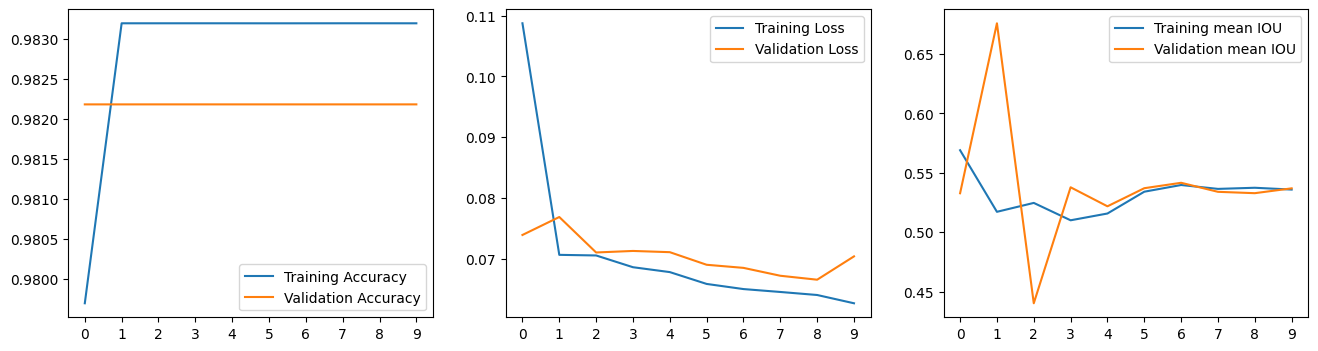


<> Evaluating model on test set <>
4/4 [==============================] - 0s 17ms/step


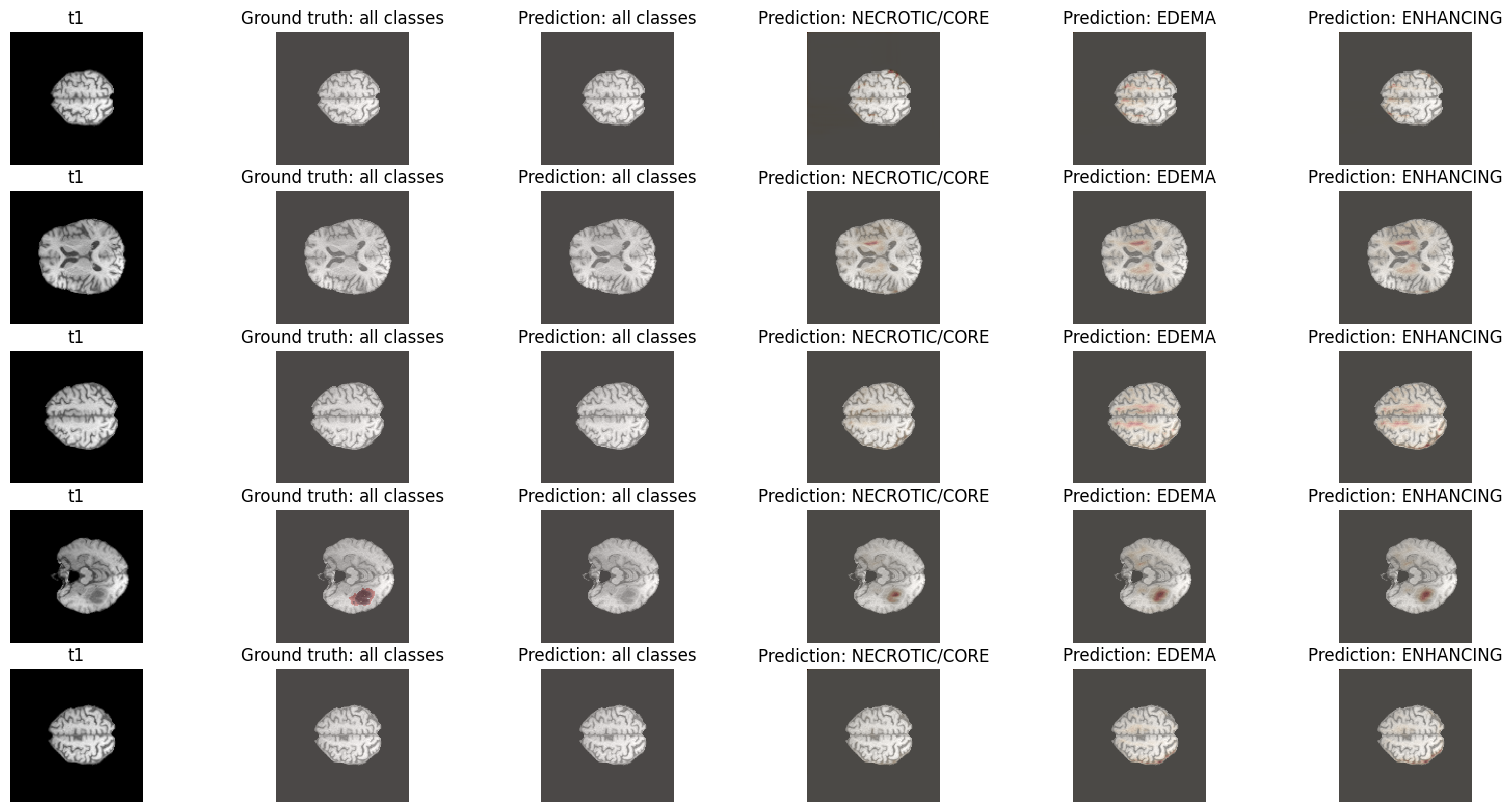

In [16]:
t1_results = run_training_job(
    model_path = "t1_unimodal",
    scan = "t1",
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    lr=0.0001
)

# T2 Unimodal Model

==== | RUNNING TRAINING JOB FOR t2_unimodal | ====


<> Setting up files <>

<> Setting up callbacks <>

<> Building data generators <>

Batch size: 1 * 100
Input shape: (128, 128, 1)
X batch shape: (100, 128, 128, 1)
Y batch shape: (100, 128, 128, 4)

<> Building model <>

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 norm (MeanStdNormLayer)     (None, 128, 128, 1)          0         ['input[0][0]']               
                                                                                                  
 encoder_block1_conv1 (Conv  (None, 128, 128, 16)         160       ['norm[0][0]']                
 2D)           

2024-02-17 10:55:43.240491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9736 - mean_io_u_3: 0.6567
Epoch 1: val_loss improved from inf to 0.06378, saving model to t2_unimodal/t2_unimodal/model_.01-0.063780.keras
249/249 [==============================] - 128s 488ms/step - loss: 0.1183 - accuracy: 0.9736 - mean_io_u_3: 0.6567 - val_loss: 0.0638 - val_accuracy: 0.9836 - val_mean_io_u_3: 0.6445 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9831 - mean_io_u_3: 0.5725
Epoch 2: val_loss improved from 0.06378 to 0.05552, saving model to t2_unimodal/t2_unimodal/model_.02-0.055524.keras
249/249 [==============================] - 121s 485ms/step - loss: 0.0661 - accuracy: 0.9831 - mean_io_u_3: 0.5725 - val_loss: 0.0555 - val_accuracy: 0.9836 - val_mean_io_u_3: 0.5175 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9831 - mean_io_u_3: 0.4994
Epoch 3: val_loss did not improve f

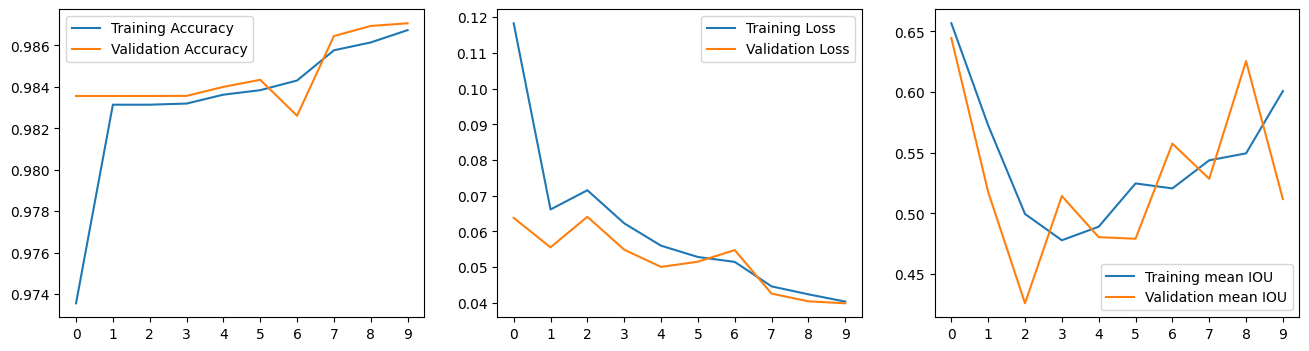


<> Evaluating model on test set <>
4/4 [==============================] - 0s 17ms/step


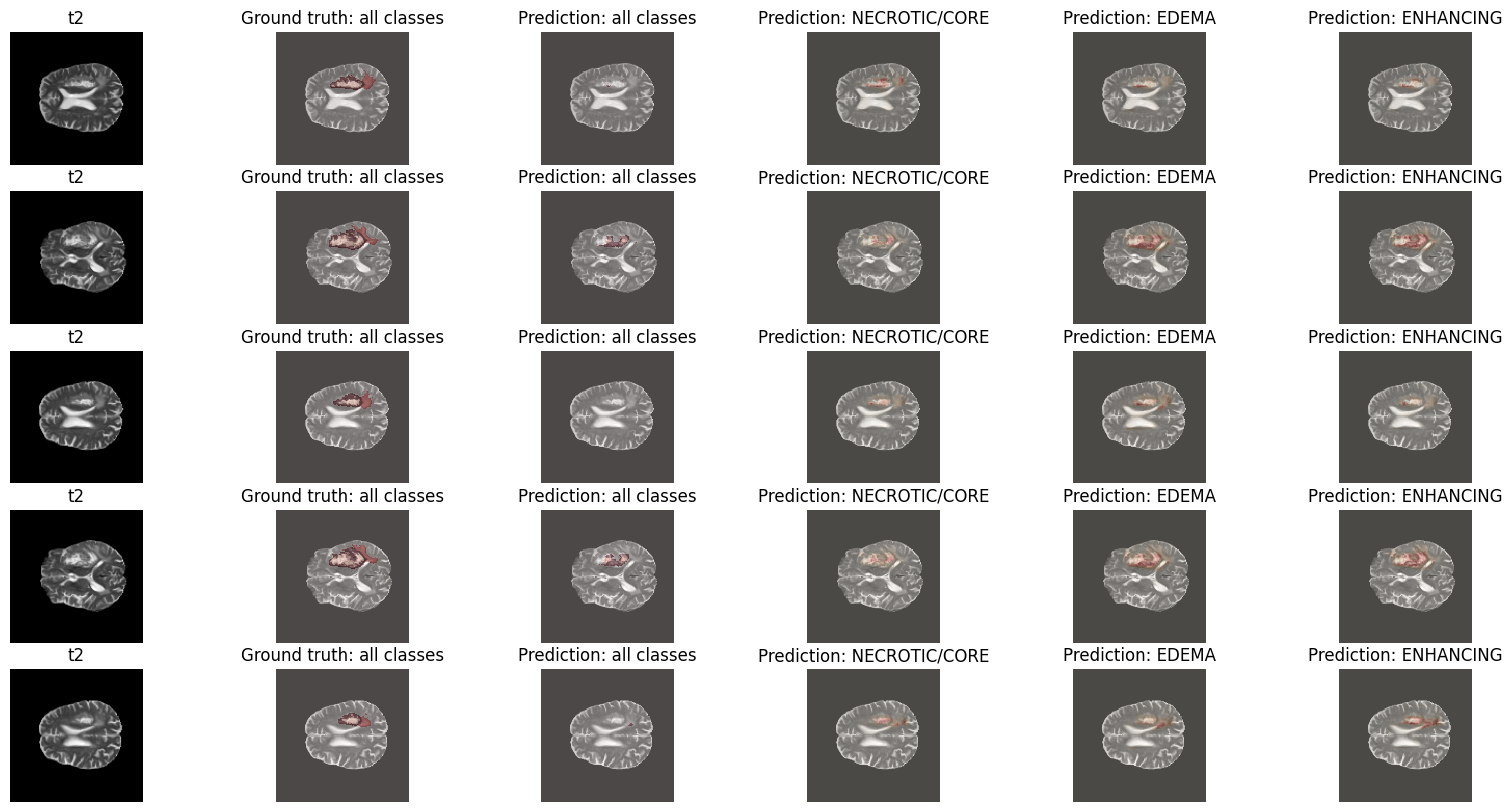

In [17]:
t2_results = run_training_job(
    model_path = "t2_unimodal",
    scan = "t2",
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    lr=0.0001
)